# Country search trends

Previously, we measured Americans' expectations about how many casualties occurred during disasters in different countries. But there are many factors that might go into these judgments. Some might be general predictive properties--population, distance from the USA, etc.--but others might be more idiosyncratic--recent conflicts, actual earthquake baserates, etc. Here, we're going to try to identify some general predictors using Google trends data. To figure out good predictors, we're going to see how much countries care about each other as measured by how much they Google each other.

Our measure for how much one Country A cares about Country B is going to be the log10 ratio of how much Country A searches for Country B divided by how much Country B searches for Country B. For example, [this search](https://www.google.com/trends/explore#q=%2Fm%2F0f8l9c%2C%20%2Fm%2F09c7w0&geo=US&date=1%2F2005%20133m&cmpt=q&tz=Etc%2FGMT%2B7) is going to allow us to see how much Americans care about the French. If we look at the summary bar graph, we're going to take log10(5/79). So, rule of thumb, less negative scores indicate the country is more searched.

In [1]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(style="white", color_codes=True)

Let's read the raw data into a csv

In [2]:
trends_df=pd.read_csv('country_trends.csv',header=None)
trends_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,Nigeria,Japan,Pakistan,United States,France,Russia,Indonesia,Mexico,Rwanda,...,Germany,Spain,Thailand,South Africa,India,Australia,Brazil,Canada,Belgium,Netherlands
1,Nigeria,68,1,0,14,2,1,0,0,0,...,2,1,0,3,2,2,1,5,1,1
2,Japan,0,66,1,16,3,2,4,3,0,...,2,2,3,2,3,4,8,2,1,1
3,Pakistan,0,1,70,4,0,1,0,0,0,...,1,0,1,0,5,2,0,2,0,0
4,United States,1,6,2,80,5,5,1,14,0,...,5,4,2,2,9,6,8,12,1,1


And now let's turn it into our country caring measure

In [3]:
self_df=pd.DataFrame({'self_num':[int(trends_df.iloc[i,i]) for i in range(1,41)],
 'Searcher':[trends_df.iloc[0,i] for i in range(1,41)]})

In [4]:
searcher=[]
searchee=[]
search_num=[]
for s_er in range(1,41):
    for s_ee in range(1,41):
        if s_er!=s_ee:
            searcher.append(trends_df.iloc[s_er,0])
            searchee.append(trends_df.iloc[0,s_ee])        
            search_num.append(int(trends_df.iloc[s_er,s_ee]))
search_df=pd.DataFrame({'Searcher':searcher,'Searchee':searchee,'search_num':search_num})
search_df=pd.merge(search_df,self_df,how='inner',on='Searcher')
search_df.loc[:,'search_score']=np.log10((search_df.loc[:,'search_num']/search_df.loc[:,'self_num'])+np.spacing(1))

Ok, first analysis--What countries were searched the most?

In [5]:
mean_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').mean().reset_index()
mean_searchee.columns=['Searchee', 'mean']
std_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').std()
num_search=np.sqrt(search_df.loc[:,['Searchee','search_score']].groupby('Searchee').size())
sem_searchee=std_searchee.divide(num_search,axis=0).reset_index()
sem_searchee.columns=['Searchee', 'SEM']

searchee_df=pd.merge(mean_searchee,sem_searchee,how='inner',on='Searchee')
searchee_df=searchee_df.sort_values(by='mean').reset_index()

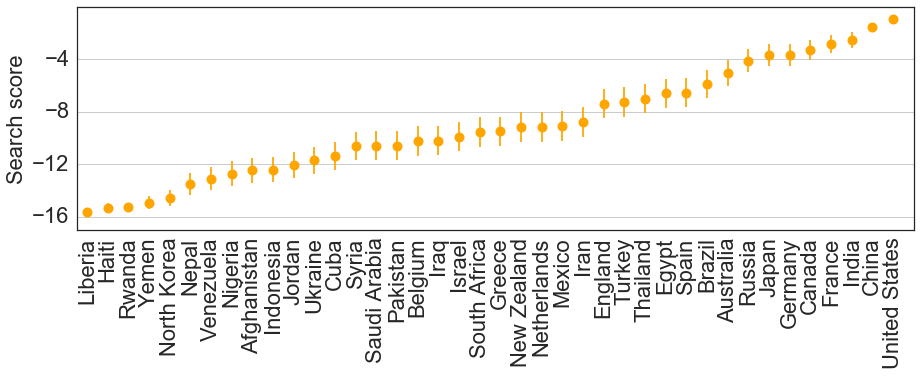

In [6]:
plt.figure(figsize=(15,4))
ax=plt.axes()
ax.yaxis.grid(True)
plt.errorbar(range(len(searchee_df)), searchee_df['mean'], yerr=searchee_df['SEM'],\
             c='orange',fmt='o',markersize=10)

plt.ylabel('Search score',fontsize='22')
plt.xticks(range(len(searchee_df)), searchee_df['Searchee'], rotation='90',fontsize=22)
plt.yticks([-16,-12,-8,-4],fontsize=22)
plt.axis([-.5, len(searchee_df), -17, 0])
plt.show()

# Country by Country Analyses

So far we've seen that certain countries are searched more often (more "popular" we might say) overall. How do these patterns vary depending on what country is doing the searching?

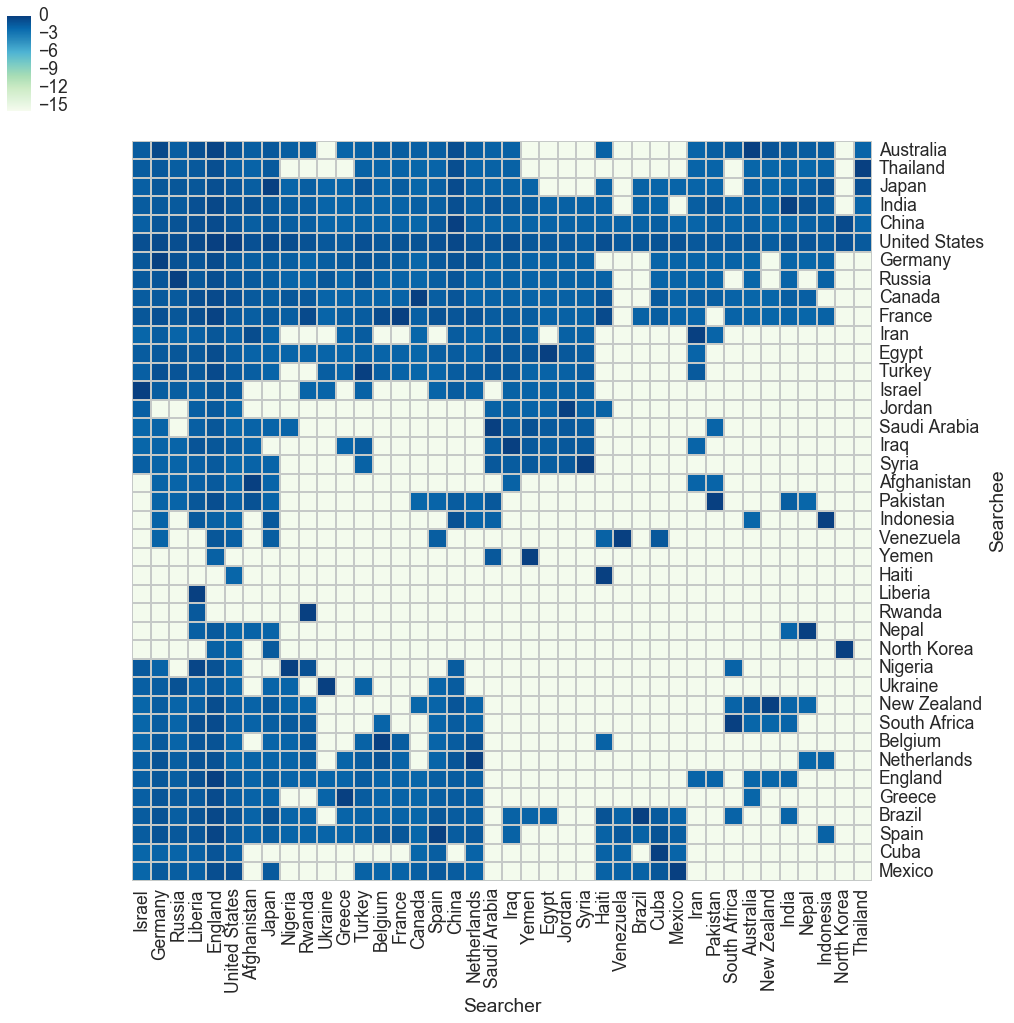

In [12]:
search_mat=search_df.pivot('Searchee','Searcher','search_score')

for i in range(0,40):
    search_mat.iloc[i,i]=0 # Setting self-search to the max
sns.set(font_scale=1.75)

g=sns.clustermap(search_mat, linewidths=1,linecolor='#c5c9c7', figsize=(15.5,15.5),vmin=-16.0,vmax=0,cmap="GnBu")
g2=g.ax_heatmap
y_labels=g2.set_yticklabels(g2.get_yticklabels(),rotation=0)
g.ax_col_dendrogram.remove()
g.ax_row_dendrogram.remove()
sns.set(style="white", color_codes=True) # Something in clustermap seems to override the set()

# Correlation with casualty estimates
Let's see how these results compare to our casualty results

In [13]:
countries=['Nigeria','Japan','Pakistan','United States','France','Russia', \
          'Indonesia','Mexico','Rwanda','Haiti','Jordan','Cuba', \
          'Liberia','North Korea','Syria','Iraq','Yemen','Ukraine', \
          'Afghanistan','Turkey','Venezuela','Egypt','Iran','Saudi Arabia', \
          'China','Israel','Greece','Nepal','England','New Zealand', \
          'Germany','Spain','Thailand','South Africa','India','Australia', \
          'Brazil','Canada','Belgium','Netherlands'] # These are mapped onto art_id in our dataset

casualty_df=pd.read_csv('../pilot_survey_v2/mturk_data_itNews_v3.csv', quotechar="'",header=None,usecols=[5,9,10,11,12,])
casualty_df.columns=['true_country','true_casualties','resp_country','resp_poster','resp_casualties']

casualty_df.loc[:,'true_casualties_log10']=np.log10(casualty_df.loc[:,'true_casualties'])
casualty_df.loc[:,'resp_casualties_log10']=np.log10(casualty_df.loc[:,'resp_casualties'])

casualty_df.loc[:,'true_name']=casualty_df.loc[:,'true_country'].apply(lambda x:countries[x])
casualty_df=casualty_df.loc[:,['true_name','resp_casualties_log10']]

In [14]:
mean_casualty=casualty_df.groupby('true_name').mean().reset_index()
std_casualty=casualty_df.groupby('true_name').std()
num_casualty=np.sqrt(casualty_df.loc[:,['true_name','resp_casualties_log10']].groupby('true_name').size())

sem_searchee=std_casualty.divide(num_casualty,axis=0).reset_index()
country_casualty=pd.merge(mean_casualty,sem_searchee,on='true_name')
country_casualty.columns=['true_name','mean_cas','SEM_cas']

searchee_df2=pd.merge(searchee_df,country_casualty,left_on='Searchee',right_on='true_name')
del searchee_df2['true_name']

print searchee_df2.head()

   index     Searchee       mean       SEM  mean_cas   SEM_cas
0     20      Liberia -15.653560  0.000000  1.742051  0.170930
1     12        Haiti -15.300984  0.352576  2.689742  0.175097
2     29       Rwanda -15.285821  0.367739  2.591224  0.142209
3     39        Yemen -14.924777  0.508566  2.355522  0.140432
4     26  North Korea -14.575293  0.606022  2.285098  0.127236


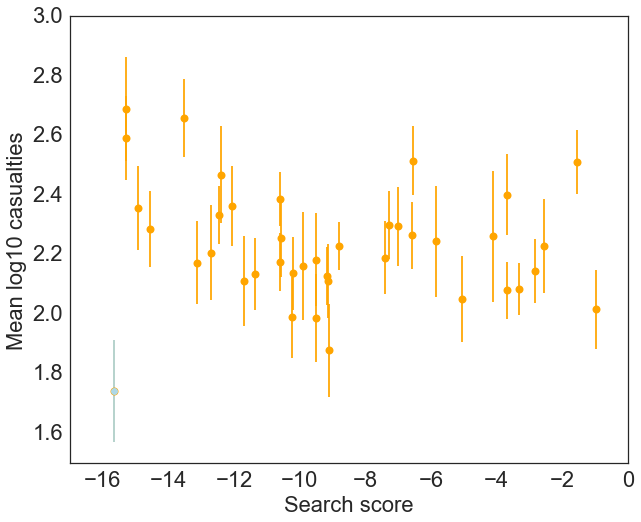

In [15]:
plt.figure(figsize=(10,8))

plt.errorbar(searchee_df2['mean'], searchee_df2['mean_cas'], yerr=searchee_df2['SEM_cas'],\
             c='orange',fmt='o',markersize=8)

# liberia
liberia_df=searchee_df2[searchee_df2['Searchee']=='Liberia']
plt.errorbar(liberia_df['mean'], liberia_df['mean_cas'], yerr=liberia_df['SEM_cas'],c='lightblue',fmt='o')

plt.xlabel('Search score',fontsize='22')
plt.ylabel('Mean log10 casualties',fontsize='22')
#plt.xticks(range(len(searchee_df)), searchee_df['searchee'], rotation='90',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.axis([-17, 0, 1.5, 3])
plt.show()

I made Liberia blue here (bottom-left). It's a weird case--It's rarely searched and in our casualty results people seem to assume it's a small island.

In [16]:
not_liberia_df=searchee_df2[searchee_df2['Searchee']!='Liberia'] # exclude liberia because it's an outlier
not_liberia_df[1:].corr().loc['mean','mean_cas']

-0.23932933330628467

Okay, cool! There's a reasonable negative correlation between how often people search a country (marginalized across countries) and how many casualties Americans expect. This bodes well for us trying to find meaningful predictors.

# Predictors

What factors predict what countries people search for? Drew Walker and I have already collected some data. First we have some demographic and location data from Wikipedia

In [17]:
wiki_df=pd.read_csv('wiki_facts.csv')
wiki_df.head()

,Country,Area (km),Population,Life Expectancy,GDP (per capita PPP),Religion1,Religion2,Language1,Language2,Latitude,Longitude
0,NORTH KOREA,120538,24983205,70.11,1800,Buddhism,Confucianism,Korean,NaN,39.0392,125.7625
1,SYRIA,185180,17064854,74.69,5100,Islam,NaN,Arabic,NaN,33.5138,36.2765
2,IRAN,1648195,81824270,71.15,17800,Islam,NaN,Farsi,NaN,35.6892,51.3890
3,IRAQ,438317,37056169,74.85,15500,Islam,NaN,Arabic,NaN,33.3128,44.3615
4,AFGHANISTAN,652230,32564342,50.87,2000,Islam,NaN,Farsi,NaN,34.5553,69.2075


And some trade information from [the Observatory of Economic Complexity](http://atlas.media.mit.edu/en/resources/data/). Note, you'll have to follow the link for the tsv; it was too large to upload to Github :/

In [18]:
trade_df=pd.read_csv('year_origin_destination_hs07_4.tsv',delimiter='\t')
country_codes={'nigeria':'nga','japan':'jpn','pakistan':'pak','united states':'usa','france':'fra','russia':'rus', 'indonesia':'idn','mexico':'mex','rwanda':'rwa','haiti':'hti','jordan':'jor','cuba':'cub', 'liberia':'lbr','north korea':'prk','syria':'syr','iraq':'irq','yemen':'yem','ukraine':'ukr', 'afghanistan':'afg','turkey':'tur','venezuela':'ven','egypt':'egy','iran':'irn','saudi arabia':'sau', 'china':'chn','israel':'isr','greece':'grc','nepal':'npl','england':'gbr','new zealand':'nzl', 'germany':'deu','spain':'esp','thailand':'tha','south africa':'zaf','india':'ind','australia':'aus', 'brazil':'bra','canada':'can','belgium':'bel','netherlands':'nld'}
trade_df.head()

,year,origin,destination,$prod_id,export_val,import_val
0,2008,abw,are,2710,NaN,7621.0
1,2008,abw,are,8517,NaN,222708.0
2,2008,abw,arg,201,NaN,157715.0
3,2008,abw,arg,202,NaN,1044521.0
4,2008,abw,arg,204,NaN,66372.0


Let's add some factors to our data

In [19]:
unidir_data=wiki_df.loc[:,['Country','Population','GDP (per capita PPP)']]

# the wiki_facts.csv data uses uppercase
search_df.loc[:,'Searchee_upper']=[i.upper() for i in search_df.loc[:,'Searchee']] 
search_df.loc[:,'Searcher_upper']=[i.upper() for i in search_df.loc[:,'Searcher']] 
search_pred_df=pd.merge(search_df,unidir_data,\
                        left_on='Searchee_upper',right_on='Country')
search_pred_df.drop(['Country','search_num','self_num'], axis=1, inplace=True)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP)
0,Japan,Nigeria,-1.832509,JAPAN,NIGERIA,126919659,38200
1,Japan,Pakistan,-1.845098,JAPAN,PAKISTAN,126919659,38200
2,Japan,United States,-1.124939,JAPAN,UNITED STATES,126919659,38200
3,Japan,France,-1.477121,JAPAN,FRANCE,126919659,38200
4,Japan,Russia,-1.139879,JAPAN,RUSSIA,126919659,38200


And let's add in a factor for shared religion

In [22]:
def comp_rel(x):
    s_ee_rel= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Religion1','Religion2']].iloc[0,:]
    s_er_rel= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Religion1','Religion2']].iloc[0,:]
    return len(set(s_ee_rel).intersection(set(s_er_rel)))>0

search_pred_df.loc[:,'com_rel']=search_pred_df.apply(comp_rel,axis=1)
print search_pred_df.query('com_rel==True').head()
print search_pred_df.query('com_rel==False').head()

    Searchee     Searcher  search_score Searchee_upper Searcher_upper  \
12     Japan  North Korea    -15.653560          JAPAN    NORTH KOREA   
23     Japan        China     -0.619789          JAPAN          CHINA   
26     Japan        Nepal     -1.596597          JAPAN          NEPAL   
31     Japan     Thailand     -0.865301          JAPAN       THAILAND   
39  Pakistan      Nigeria    -15.653560       PAKISTAN        NIGERIA   

    Population  GDP (per capita PPP) com_rel  
12   126919659                 38200    True  
23   126919659                 38200    True  
26   126919659                 38200    True  
31   126919659                 38200    True  
39   199085847                  4900    True  
  Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
0    Japan        Nigeria     -1.832509          JAPAN        NIGERIA   
1    Japan       Pakistan     -1.845098          JAPAN       PAKISTAN   
2    Japan  United States     -1.124939          JAPAN  UNIT

And one for common language

In [23]:
def comp_lang(x):
    s_ee_rel= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Language1','Language2']].iloc[0,:]
    s_ee_set=set(s_ee_rel)
    try:
        s_ee_set.remove(np.nan)
    except:
        pass
    
    s_er_rel= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Language1','Language2']].iloc[0,:]
    s_er_set=set(s_er_rel)
    try:
        s_er_set.remove(np.nan)
    except:
        pass        

    return len(s_ee_set.intersection(set(s_er_set)))>0

search_pred_df.loc[:,'com_lang']=search_pred_df.apply(comp_lang,axis=1)
print search_pred_df.query('com_lang==True').head()
print search_pred_df.query('com_lang==False').head()

    Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
39  Pakistan        Nigeria    -15.653560       PAKISTAN        NIGERIA   
41  Pakistan  United States     -1.602060       PAKISTAN  UNITED STATES   
48  Pakistan         Jordan    -15.653560       PAKISTAN         JORDAN   
50  Pakistan        Liberia     -1.135663       PAKISTAN        LIBERIA   
66  Pakistan        England     -0.708515       PAKISTAN        ENGLAND   

    Population  GDP (per capita PPP) com_rel com_lang  
39   199085847                  4900    True     True  
41   199085847                  4900    True     True  
48   199085847                  4900    True     True  
50   199085847                  4900    True     True  
66   199085847                  4900    True     True  
  Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
0    Japan        Nigeria     -1.832509          JAPAN        NIGERIA   
1    Japan       Pakistan     -1.845098          JAPAN       PAKIST

And the distance between capitals

In [24]:
def cap_dist(x):
    s_ee_ll= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Latitude','Longitude']].iloc[0,:]
    s_er_ll= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Latitude','Longitude']].iloc[0,:]
    return np.sqrt(np.sum(pow(s_ee_ll-s_er_ll,2)))

search_pred_df.loc[:,'dist']=search_pred_df.apply(cap_dist,axis=1)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP),com_rel,com_lang,dist
0,Japan,Nigeria,-1.832509,JAPAN,NIGERIA,126919659,38200,False,False,134.943381
1,Japan,Pakistan,-1.845098,JAPAN,PAKISTAN,126919659,38200,False,False,66.627438
2,Japan,United States,-1.124939,JAPAN,UNITED STATES,126919659,38200,False,False,216.724335
3,Japan,France,-1.477121,JAPAN,FRANCE,126919659,38200,False,False,137.969239
4,Japan,Russia,-1.139879,JAPAN,RUSSIA,126919659,38200,False,False,104.028071


And finally trade

In [25]:
trade_df.loc[:,'sumtrade']=trade_df.loc[:,['export_val','import_val']].sum(axis=1)
trade_2012_df=trade_df.loc[:,['year','origin','destination','sumtrade']].\
    query('year==2012').groupby(['origin','destination']).mean().reset_index()
trade_2012_df.head()

,origin,destination,year,sumtrade
0,abw,arg,2012,74302.376230
1,abw,aut,2012,43801.052632
2,abw,aze,2012,83842.000000
3,abw,bgr,2012,21949.980000
4,abw,bhs,2012,198171.528571


In [26]:
def comp_trade(x):
    origin_id=trade_2012_df.origin==country_codes[x.Searcher_upper.lower()]
    destination_id=trade_2012_df.destination==country_codes[x.Searchee_upper.lower()]   
    find_ind=np.logical_and(destination_id , origin_id)
    val= trade_2012_df.loc[find_ind,'sumtrade'].reset_index()
    try:
        val_num=val.iloc[0,0]
    except:
        val_num=np.nan

    return val_num

search_pred_df.loc[:,'sumtrade']=search_pred_df.apply(comp_trade,axis=1)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP),com_rel,com_lang,dist,sumtrade
0,Japan,Nigeria,-1.832509,JAPAN,NIGERIA,126919659,38200,False,False,134.943381,19527.0
1,Japan,Pakistan,-1.845098,JAPAN,PAKISTAN,126919659,38200,False,False,66.627438,20846.0
2,Japan,United States,-1.124939,JAPAN,UNITED STATES,126919659,38200,False,False,216.724335,27923.0
3,Japan,France,-1.477121,JAPAN,FRANCE,126919659,38200,False,False,137.969239,9413.0
4,Japan,Russia,-1.139879,JAPAN,RUSSIA,126919659,38200,False,False,104.028071,22972.0


And cleanup, because I'm neurotic

In [54]:
search_pred_df2=search_pred_df.drop(['Searchee_upper','Searcher_upper'], axis=1)
search_pred_df2.dropna(inplace=True) # For some reason, no belgium trade data
search_pred_df2.reset_index(inplace=True)
search_pred_df2.loc[:,'PopLog']=np.log10(search_pred_df2.loc[:,'Population'])
search_pred_df2.loc[:,'GDP_log']=np.log10(search_pred_df2.loc[:,'GDP (per capita PPP)'])
search_pred_df2.head()

,index,Searchee,Searcher,search_score,Population,GDP (per capita PPP),com_rel,com_lang,dist,sumtrade,PopLog,GDP_log
0,0,Japan,Nigeria,-1.832509,126919659,38200,False,False,134.943381,19527.0,8.103529,4.582063
1,1,Japan,Pakistan,-1.845098,126919659,38200,False,False,66.627438,20846.0,8.103529,4.582063
2,2,Japan,United States,-1.124939,126919659,38200,False,False,216.724335,27923.0,8.103529,4.582063
3,3,Japan,France,-1.477121,126919659,38200,False,False,137.969239,9413.0,8.103529,4.582063
4,4,Japan,Russia,-1.139879,126919659,38200,False,False,104.028071,22972.0,8.103529,4.582063


If we look at the parameters, we can see some correlations--Unsurprisingly, people search for populous, rich countries that speak their language more.

In [72]:
search_pred_df2.loc[:,['search_score','PopLog','GDP_log','com_rel','com_lang','sumtrade']].corr()

,search_score,PopLog,GDP_log,com_rel,com_lang,sumtrade
search_score,1.000000,0.332950,0.393744,-0.070911,0.200079,-0.075671
PopLog,0.332950,1.000000,0.121564,-0.232320,-0.047185,0.007255
GDP_log,0.393744,0.121564,1.000000,0.091545,0.014971,0.009637
com_rel,-0.070911,-0.232320,0.091545,1.000000,0.119902,0.064162
com_lang,0.200079,-0.047185,0.014971,0.119902,1.000000,0.007728
sumtrade,-0.075671,0.007255,0.009637,0.064162,0.007728,1.000000


And now let's see how well we can predict how much countries Google each other!

In [50]:
md = smf.mixedlm('search_score ~PopLog+dist+GDP_log+com_rel+com_lang+sumtrade', search_pred_df2, groups=search_pred_df2['Searcher'])
mdf = md.fit() 
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  search_score
No. Observations:    1364     Method:              REML        
No. Groups:          39       Scale:               26.0027     
Min. group size:     26       Likelihood:          -4218.9978  
Max. group size:     38       Converged:           Yes         
Mean group size:     35.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        -55.889    2.503 -22.324 0.000 -60.795 -50.982
com_rel[T.True]   -1.768    0.469  -3.769 0.000  -2.687  -0.849
com_lang[T.True]   4.537    0.426  10.639 0.000   3.701   5.373
PopLog             3.400    0.252  13.497 0.000   2.906   3.894
dist              -0.013    0.003  -4.477 0.000  -0.019  -0.007
GDP_log            5.843    0.303  19.265 0.000   5.2

Ok! So all of these things predict how much countries Google each other, except trade.

In [57]:
search_pred_df3=search_pred_df.drop(['Searchee_upper','Searcher_upper','sumtrade'], axis=1)
search_pred_df3.loc[:,'PopLog']=np.log10(search_pred_df3.loc[:,'Population'])
search_pred_df3.loc[:,'GDP_log']=np.log10(search_pred_df3.loc[:,'GDP (per capita PPP)'])
search_pred_df3.reset_index(inplace=True)

md = smf.mixedlm('search_score~PopLog+dist+GDP_log+com_rel+com_lang', search_pred_df3, groups=search_pred_df3['Searcher'])
mdf = md.fit() 
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  search_score
No. Observations:    1560     Method:              REML        
No. Groups:          40       Scale:               25.9153     
Min. group size:     39       Likelihood:          -4808.8460  
Max. group size:     39       Converged:           Yes         
Mean group size:     39.0                                      
---------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept        -55.320    2.085 -26.531 0.000 -59.407 -51.234
com_rel[T.True]   -1.562    0.432  -3.617 0.000  -2.408  -0.715
com_lang[T.True]   4.743    0.404  11.743 0.000   3.952   5.535
PopLog             3.397    0.236  14.419 0.000   2.935   3.858
dist              -0.012    0.003  -4.285 0.000  -0.017  -0.006
GDP_log            5.295    0.272  19.452 0.000   4.7

# Predicting casualties

In [94]:
usa_search=search_pred_df3.loc[search_pred_df3['Searcher']=='United States',:].reset_index()

usa_search=pd.merge(usa_search,searchee_df2.loc[:,['Searchee','mean_cas']],on='Searchee')
# Removing Liberia since Americans don't actually seem to know what it is
usa_search=usa_search.loc[usa_search.Searchee!='Liberia',:]
usa_search.drop(['level_0','index'],axis=1,inplace=True)
usa_search.head()

,Searchee,Searcher,search_score,Population,GDP (per capita PPP),com_rel,com_lang,dist,PopLog,GDP_log,mean_cas
0,Japan,United States,-1.124939,126919659,38200,False,False,216.724335,8.103529,4.582063,2.400800
1,Pakistan,United States,-1.602060,199085847,4900,True,True,150.190787,8.299040,3.690196,2.256767
2,France,United States,-1.204120,66553766,41400,True,False,79.984592,7.823173,4.617000,2.144102
3,Russia,United States,-1.204120,142423773,23700,True,False,115.860463,8.153582,4.374748,2.260736
4,Indonesia,United States,-1.903090,255993674,11300,True,False,189.274663,8.408229,4.053078,2.467763


In [95]:
md = smf.mixedlm('mean_cas~PopLog+dist+com_rel+com_lang+GDP_log', usa_search, groups=usa_search['Searcher'])
mdf = md.fit() 
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  mean_cas
No. Observations:    38       Method:              REML    
No. Groups:          1        Scale:               0.0224  
Min. group size:     38       Likelihood:          4.0371  
Max. group size:     38       Converged:           Yes     
Mean group size:     38.0                                  
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         3.156    0.467  6.765 0.000  2.241  4.070
com_rel[T.True]  -0.103    0.091 -1.125 0.261 -0.282  0.076
com_lang[T.True] -0.080    0.053 -1.501 0.133 -0.184  0.024
PopLog           -0.002    0.049 -0.038 0.970 -0.098  0.094
dist              0.000    0.001  0.161 0.872 -0.001  0.001
GDP_log          -0.189    0.055 -3.417 0.001 -0.297 -0.081
Intercept RE      0.022                            

Ok so it comes down to--Americans' expectations are determined almost solely by how wealthy a country is: The wealthier another country is, the fewer casualties there have to be for Americans to care. 

This requires further interpretation. Americans could be elitist--as the country with the highest GDP in the world, we only care about other countries with high GDPs--or it could be rational--a high GDP tends to translate into robust infrastructures that are robust to disasters like earthquakes. One way to get around this confound in the future could be to use another type of disaster that is less dependent on the quality of a country's infrastructure.